# GAT



In [1]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    path_to_file = '/content/gdrive/My Drive/CS6208_codes/codes/labs_lecture05'
    print(path_to_file)
    # change current path to the folder containing "path_to_file"
    os.chdir(path_to_file)
    !pwd
    !pip install dgl # Install DGL

Mounted at /content/gdrive
/content/gdrive/My Drive/CS6208_codes/codes/labs_lecture05
/content/gdrive/MyDrive/CS6208_codes/codes/labs_lecture05
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 82.5 MB/s eta 0:00:00


In [2]:
# Import libs
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import dgl
from dgl import DGLGraph
from dgl.data import MiniGCDataset

import time

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline 

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
    

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


# Implementation of GAT with DGL

In [3]:
# Model for transductive learning task (Cora) with Dropout and L2

class GATLayer(nn.Module):
    
    def __init__(self, input_dim, output_dim):
        super(GATLayer, self).__init__()
        self.output_dim = output_dim
        self.W = nn.Linear(input_dim, output_dim, bias=True)
        self.A = nn.Linear(2 * output_dim, 1, bias=True)
        self.dropout = nn.Dropout(0.6)
        
        self.relu = nn.LeakyReLU(0.2)
        self.softmax = nn.Softmax(dim=1)
        nn.init.xavier_normal_(self.W.weight, gain=nn.init.calculate_gain('relu'))
        nn.init.xavier_normal_(self.A.weight, gain=nn.init.calculate_gain('relu'))

    def message_func(self, edges):
        Wh_j = edges.src['Wh']
        Wh_i = edges.dst['Wh']
        e_ij = self.A(torch.cat([Wh_i, Wh_j], dim=1))
        e_ij = self.relu(e_ij)
        return {'Wh_j' : Wh_j, 'e_ij' : e_ij}

    def reduce_func(self, nodes):
        e_ij = nodes.mailbox['e_ij']
        alpha_ij = self.softmax(e_ij)
        Wh_j = nodes.mailbox['Wh_j']
        h = torch.sum(alpha_ij * Wh_j, dim=1)
        return {'h': h}
    
    def forward(self, g, h):
        g.ndata['h'] = h
        Wh = self.W(h)
        g.ndata['Wh'] = Wh
        g.update_all(self.message_func, self.reduce_func)
        h = g.ndata['h']
        return self.dropout(h)

class MultiHeadGATLayer(nn.Module):
    def __init__(self, input_dim, output_dim, num_heads, combination='cat'):
        super(MultiHeadGATLayer, self).__init__()
        self.combination = combination
        self.heads = nn.ModuleList([GATLayer(input_dim, output_dim) for _ in range(num_heads)])

    def forward(self, g, h):
        head_outs = [head(g, h) for head in self.heads]
        if self.combination == 'cat':
          return torch.cat(head_outs, dim=1)
        elif self.combination == 'avg':
          return torch.mean(torch.stack(head_outs), dim=0)
  
    
class GAT_Net(nn.Module):
    
    def __init__(self, net_parameters):
        super(GAT_Net, self).__init__()
        input_dim = net_parameters['input_dim']
        hidden_dim = net_parameters['hidden_dim']
        output_dim = net_parameters['output_dim']
        num_heads = net_parameters['num_heads']
        combination_methods = net_parameters['combination_methods']
        L = net_parameters['L']
        self.elu = nn.ELU()
        self.softmax = nn.Softmax(dim=1)
        self.dropout = nn.Dropout(0.6)

        self.layer_list = [MultiHeadGATLayer(input_dim, hidden_dim, num_heads[0], combination=combination_methods[0])]
        for i in range(1, L-1):
          self.layer_list.append(MultiHeadGATLayer(hidden_dim * num_heads[i], hidden_dim, num_heads[i], combination=combination_methods[i]))
        self.layer_list.append(MultiHeadGATLayer(hidden_dim * num_heads[-2], output_dim, num_heads[-1], combination=combination_methods[-1]))
        self.MultiHeadGATlayers = nn.ModuleList(self.layer_list) 
        
    def forward(self, g, h):
        for layer in self.MultiHeadGATlayers[:-1]:
          h = self.dropout(h)
          h = layer(g, h)
          h = self.elu(h)
        if len(self.MultiHeadGATlayers) > 1:
          h = self.dropout(h)
          h = self.MultiHeadGATlayers[-1](g, h)
          h = self.softmax(h)
        return h
    
    def loss(self, y_scores, y_labels):
        loss = nn.CrossEntropyLoss()(y_scores, y_labels)
        return loss        
        
    def accuracy(self, scores, targets):
        scores = scores.detach().argmax(dim=1)
        acc = (scores==targets).float().mean().item()
        return acc
    
    def update(self, lr):       
        # Add L2 
        update = torch.optim.Adam(self.parameters(), lr=lr, weight_decay=0.0005)
        return update



# Load Dataset and setup model

In [4]:
from dgl.data import CoraGraphDataset

def load_cora_data():
    dataset = CoraGraphDataset()
    g = dataset[0]
    features = g.ndata['feat']
    labels = g.ndata['label']
    train_mask = g.ndata['train_mask']
    test_mask = g.ndata['test_mask']
    return g, features, labels, train_mask


# load data
g, features, labels, train_mask = load_cora_data()
val_mask = g.ndata['val_mask']
test_mask = g.ndata['test_mask']

Extracting file to /root/.dgl/cora_v2
Finished data loading and preprocessing.
  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done saving data into cached files.


# Train the model

GAT_Net(
  (elu): ELU(alpha=1.0)
  (softmax): Softmax(dim=1)
  (dropout): Dropout(p=0.6, inplace=False)
  (MultiHeadGATlayers): ModuleList(
    (0): MultiHeadGATLayer(
      (heads): ModuleList(
        (0-7): 8 x GATLayer(
          (W): Linear(in_features=1433, out_features=8, bias=True)
          (A): Linear(in_features=16, out_features=1, bias=True)
          (dropout): Dropout(p=0.6, inplace=False)
          (relu): LeakyReLU(negative_slope=0.2)
          (softmax): Softmax(dim=1)
        )
      )
    )
    (1): MultiHeadGATLayer(
      (heads): ModuleList(
        (0): GATLayer(
          (W): Linear(in_features=64, out_features=7, bias=True)
          (A): Linear(in_features=14, out_features=1, bias=True)
          (dropout): Dropout(p=0.6, inplace=False)
          (relu): LeakyReLU(negative_slope=0.2)
          (softmax): Softmax(dim=1)
        )
      )
    )
  )
)
Epoch 000 | Loss 1.9481 | Val loss 1.9442 | Test loss 1.9442 | Val acc 0.1140 | Test acc 0.1070
Epoch 001 | Loss

<Figure size 640x480 with 0 Axes>

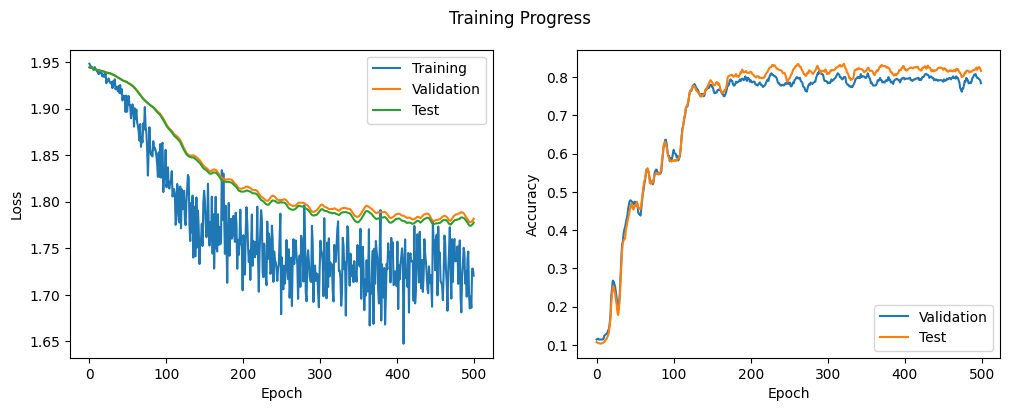

In [5]:
# network parameters
net_parameters = {}
net_parameters['input_dim'] = features.size()[1]
net_parameters['hidden_dim'] = 8
net_parameters['num_heads'] = [8, 1]
net_parameters['combination_methods'] = ['cat', 'avg']
net_parameters['output_dim'] = 7
net_parameters['L'] = 2


model = GAT_Net(net_parameters)
print(model)

optimizer = model.update(lr=0.005)
patience = 100
best_acc = 0.0
best_loss = float('inf')
best_epoch = 0

train_losses = []
val_losses = []
test_losses = []
val_accs = []
test_accs = []

def draw_plot(train_losses, val_losses, test_losses, val_accs, test_accs):
    plt.clf()
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle('Training Progress')
    
    axes[0].plot(train_losses, label='Training')
    axes[0].plot(val_losses, label='Validation')
    axes[0].plot(test_losses, label='Test')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    
    axes[1].plot(val_accs, label='Validation')
    axes[1].plot(test_accs, label='Test')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    
    plt.show()

# Train the model
num_epochs = 500
for epoch in range(num_epochs):
    model.train()
    
    logits = model(g, features)
    train_logits = logits[train_mask]
    train_labels = labels[train_mask]
    loss = model.loss(train_logits, train_labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Eval
    model.eval()
    with torch.no_grad():
        val_logits = model(g, features)[val_mask]
        val_labels = labels[val_mask]
        val_loss = model.loss(val_logits, val_labels)
        val_acc = model.accuracy(val_logits, val_labels)


        if val_loss < best_loss:
            best_loss = val_loss
            best_epoch = epoch
            torch.save(model.state_dict(), 'best_loss_model.pt')
            
        if val_acc > best_acc:
            best_acc = val_acc
            best_epoch = epoch
            torch.save(model.state_dict(), 'best_acc_model.pt')
        
        # Early stopping on accuracy
        if epoch - best_epoch > patience:
            print("Early stopping")
            break
        
        test_logits = model(g, features)[test_mask]
        test_labels = labels[test_mask]
        test_loss = model.loss(test_logits, test_labels)
        test_acc = model.accuracy(test_logits, test_labels)
    
    train_losses.append(loss.item())
    val_losses.append(val_loss.item())
    test_losses.append(test_loss.item())
    val_accs.append(val_acc)
    test_accs.append(test_acc)
    

    print("Epoch {:03d} | Loss {:.4f} | Val loss {:.4f} | Test loss {:.4f} | Val acc {:.4f} | Test acc {:.4f}".format(
        epoch, loss.item(), val_loss.item(), test_loss.item(), val_acc, test_acc))
    
    # # Plot metrics every 10 epoch
    # if epoch % 10 == 0 and epoch != 0:
    #   draw_plot(train_losses=train_losses, val_losses=val_losses, test_losses=test_losses, val_accs=val_accs, test_accs=test_accs)

draw_plot(train_losses=train_losses, val_losses=val_losses, test_losses=test_losses, val_accs=val_accs, test_accs=test_accs)

# Model for PPI Dataset (with Residual Connection)

In [6]:
# GAT For PPI Dataset with Residual Connection and without dropout and L2

class GATLayer_v2(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(GATLayer_v2, self).__init__()
        self.output_dim = output_dim
        self.W = nn.Linear(input_dim, output_dim, bias=True)
        self.A = nn.Linear(2 * output_dim, 1, bias=True)
        
        self.relu = nn.LeakyReLU(0.2)
        self.softmax = nn.Softmax(dim=1)
        nn.init.xavier_normal_(self.W.weight, gain=nn.init.calculate_gain('relu'))
        nn.init.xavier_normal_(self.A.weight, gain=nn.init.calculate_gain('relu'))

    def message_func(self, edges):
        Wh_j = edges.src['Wh']
        Wh_i = edges.dst['Wh']
        e_ij = self.A(torch.cat([Wh_i, Wh_j], dim=1))
        e_ij = self.relu(e_ij)
        return {'Wh_j' : Wh_j, 'e_ij' : e_ij}

    def reduce_func(self, nodes):
        e_ij = nodes.mailbox['e_ij']
        alpha_ij = self.softmax(e_ij)
        Wh_j = nodes.mailbox['Wh_j']
        h = torch.sum(alpha_ij * Wh_j, dim=1)
        return {'h': h}
    
    def forward(self, g, h):
        g.ndata['h'] = h
        Wh = self.W(h)
        g.ndata['Wh'] = Wh
        g.update_all(self.message_func, self.reduce_func)
        h = g.ndata['h']
        return h

class MultiHeadGATLayer_v2(nn.Module):
    def __init__(self, input_dim, output_dim, num_heads, combination='cat'):
        super(MultiHeadGATLayer_v2, self).__init__()
        self.combination = combination
        self.heads = nn.ModuleList([GATLayer_v2(input_dim, output_dim) for _ in range(num_heads)])

    def forward(self, g, h):
        head_outs = [head(g, h) for head in self.heads]
        if self.combination == 'cat':
          return torch.cat(head_outs, dim=1)
        elif self.combination == 'avg':
          return torch.mean(torch.stack(head_outs), dim=0)
  
    
class GATNet_v2(nn.Module):
    
    def __init__(self, net_parameters):
        super(GATNet_v2, self).__init__()
        input_dim = net_parameters['input_dim']
        hidden_dim = net_parameters['hidden_dim']
        output_dim = net_parameters['output_dim']
        num_heads = net_parameters['num_heads']
        combination_methods = net_parameters['combination_methods']
        hidden_dims = net_parameters['hidden_dims']
        L = net_parameters['L']
        self.elu = nn.ELU()
        self.softmax = nn.Softmax(dim=1)

        self.layer_list = [MultiHeadGATLayer_v2(input_dim, hidden_dims[0], num_heads[0], combination=combination_methods[0])]
        for i in range(1, L-1):
          self.layer_list.append(MultiHeadGATLayer_v2(hidden_dims[i-1] * num_heads[i], hidden_dims[i], num_heads[i], combination=combination_methods[i]))
        self.layer_list.append(MultiHeadGATLayer_v2(hidden_dims[-2] * num_heads[-2], output_dim, num_heads[-1], combination=combination_methods[-1]))
        self.MultiHeadGATlayers = nn.ModuleList(self.layer_list) 
        
    def forward(self, g, h):
        h = self.MultiHeadGATlayers[0](g, h)
        h = self.elu(h)
        for layer in self.MultiHeadGATlayers[1:-1]:
          h_res = h.clone()
          h = layer(g, h)
          h = self.elu(h_res+h)
        if len(self.MultiHeadGATlayers) > 1:
          h = self.MultiHeadGATlayers[-1](g, h)
          h = torch.sigmoid(h)
        return h
    
    def loss(self, y_scores, y_labels):
        loss = nn.CrossEntropyLoss()(y_scores, y_labels)
        return loss        
        
    def accuracy(self, scores, targets):
        scores = scores.detach().sigmoid()
        scores = (scores > 0.5).float()
        tp = (scores * targets).sum().item()
        fp = ((1 - targets) * scores).sum().item()
        tn = ((1 - targets) * (1 - scores)).sum().item()
        fn = (targets * (1 - scores)).sum().item()
        precision = tp / (tp + fp + 1e-8)
        recall = tp / (tp + fn + 1e-8)
        f1 = 2 * (precision * recall) / (precision + recall + 1e-8)
        return f1
    
    def update(self, lr):       
        update = torch.optim.Adam(self.parameters(), lr=lr)
        return update

In [ ]:
import torch
from dgl.data import PPIDataset


# Load datasets
train_dataset = PPIDataset(mode="train")
val_dataset = PPIDataset(mode="valid")
test_dataset = PPIDataset(mode="test")

# Network parameters for PPI
net_parameters = {}
net_parameters['input_dim'] = train_dataset.graphs[0].ndata["feat"].size()[1]
net_parameters['hidden_dim'] = 256
net_parameters['num_heads'] = [4, 4, 3]
net_parameters['hidden_dims'] = [256, 256, 256]
net_parameters['combination_methods'] = ['cat', 'cat', 'avg']
net_parameters['output_dim'] = train_dataset.num_labels
net_parameters['L'] = 3

model = GATNet_v2(net_parameters)
print(model)

# Note: I didn't fully train the PPI dataset because 
# training even a single epoch on CPU takes a lot of time. 
# However, when I tried to run it on GPU, 
# I encountered compatibility issues with DGL and Colab's CUDA version.

Extracting file to /root/.dgl/ppi
